In [1]:
import sys
sys.path.append("..")
from utilities import *

warnings.filterwarnings("ignore")

raw_data = pd.read_excel("../data/Datos_Market_copy.xlsx")

sa = SalesAnalysis(raw_data)

/Users/oscarjimenezbou/Documents/TFG_ADE/code/TFG/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [2]:
%run 1_preprocessing_data.ipynb

94 5 40
📊 ESTADÍSTICAS DESCRIPTIVAS - VARIABLES NUMÉRICAS
        volume.sales        price
count    3256.000000  3256.000000
mean    40150.619340     2.022834
std     56176.374822     0.785525
min       452.360000     0.375449
25%      6606.907500     1.450135
50%     17814.810000     2.002405
75%     53415.565000     2.591298
max    539900.600000     4.036102


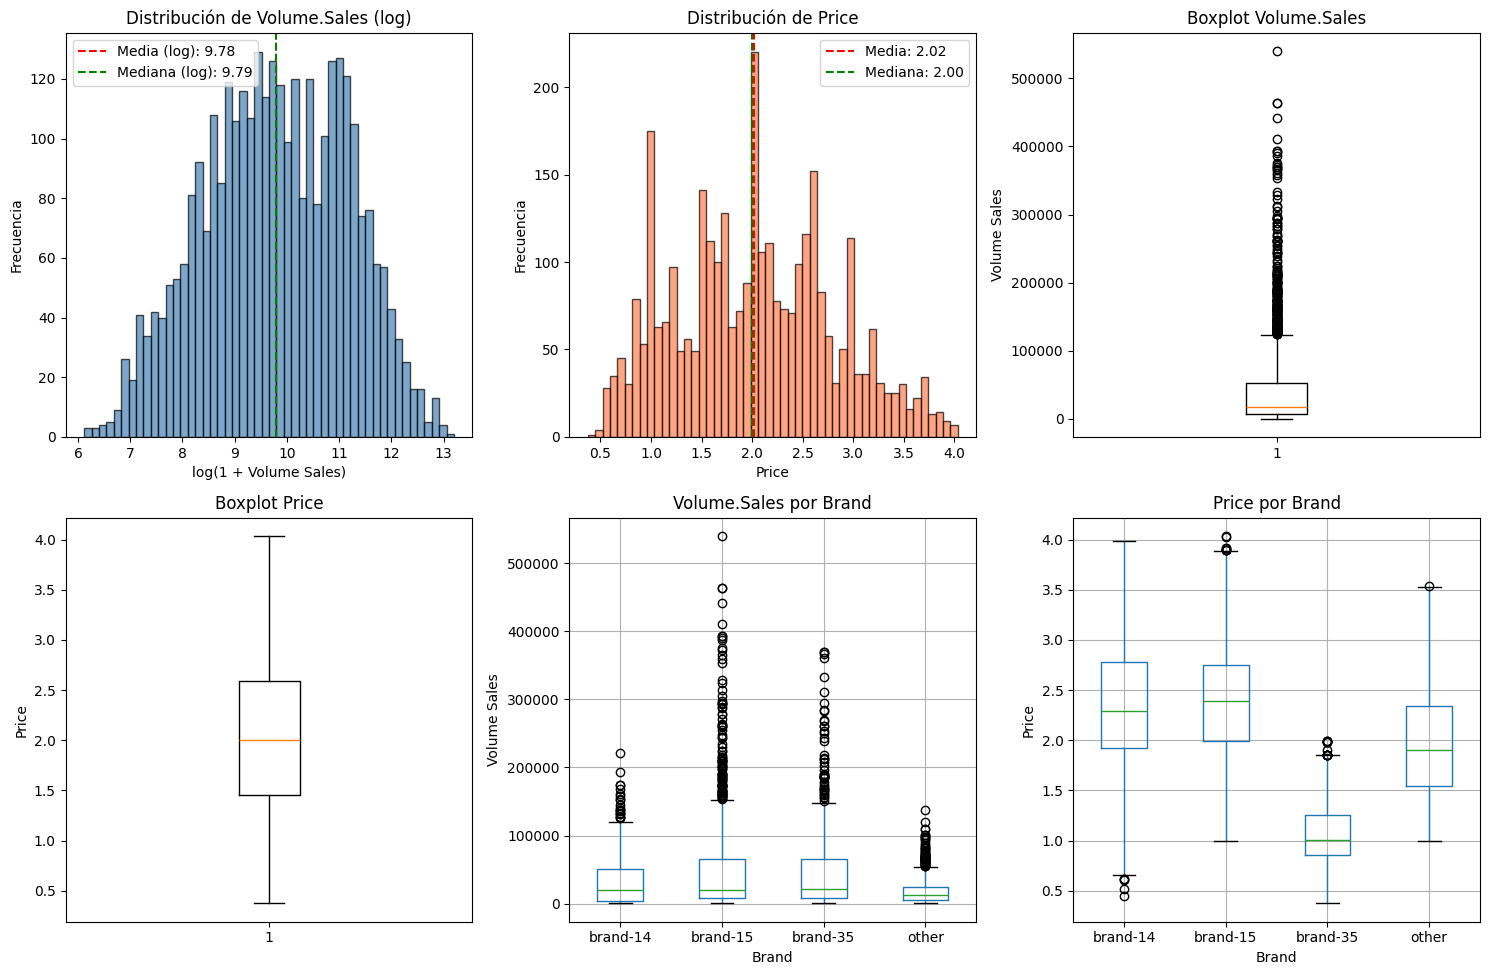


📊 DISTRIBUCIÓN POR CATEGORÍAS


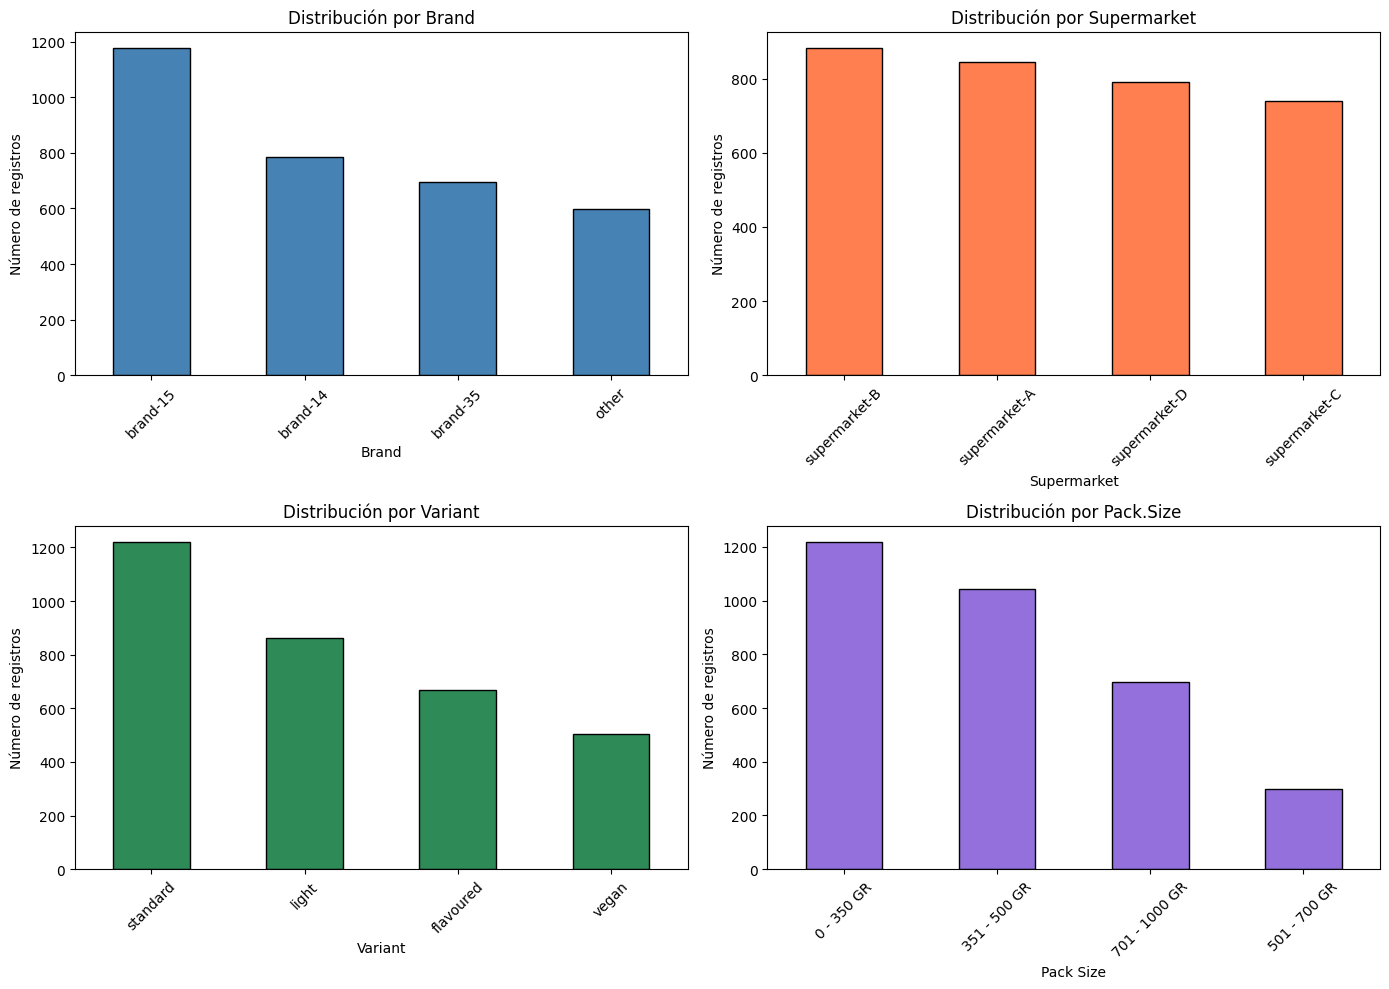


📊 CORRELACIÓN: VOLUME.SALES vs PRICE
Correlación de Pearson: 0.0398


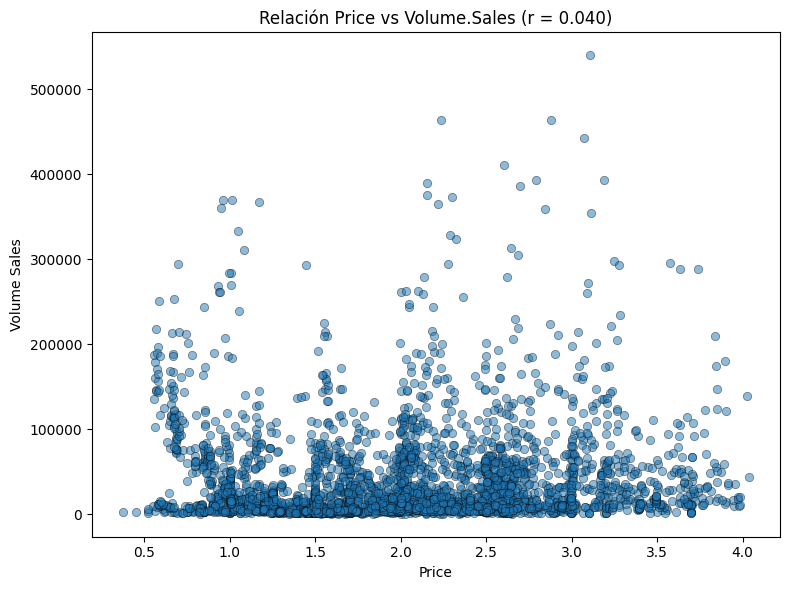

In [3]:
(
    data,
    filter_data, 
    train_data,
    test_data,
    y_train_boxcox,
    y_test_boxcox,
    boxcox_transformation_info,
) = run_preprocessing(ARIMA_model=False)


MODELO DE REGRESIÓN

In [4]:
model, selected_var, deleted_var = sa.regression_with_backward_elimination(train_data, verbose=True)
print(model.summary())


Fórmula del modelo:
volume_sales ~ price + C(supermarket) + C(variant) + C(pack_size) + C(brand) + (price + C(brand)) ** 2
Iteración 1: Eliminando 'C(supermarket)[T.supermarket-C]' (p-valor = 0.9789)
Iteración 2: Eliminando 'C(brand)[T.brand-15]' (p-valor = 0.4554)
Iteración 3: Eliminando 'price:C(brand)[T.other]' (p-valor = 0.3833)
Iteración 4: Eliminando 'C(brand)[T.other]' (p-valor = 0.4051)
Iteración 5: Todas las variables restantes son significativas (p-valor ≤ 0.05)

Resumen:
  Variables iniciales: 17
  Variables seleccionadas: 13
  Variables eliminadas: 4
  R² ajustado: 0.4793
                            OLS Regression Results                            
Dep. Variable:           volume_sales   R-squared:                       0.482
Model:                            OLS   Adj. R-squared:                  0.479
Method:                 Least Squares   F-statistic:                     204.7
Date:                Wed, 04 Feb 2026   Prob (F-statistic):               0.00
Time:         

In [5]:
x_train_exogs = sa.x_train_exog_custom(train_data, selected_var, model)
if False:
    print(f"\nShape de X_train_exox: {x_train_exogs.shape}")
    print("Columnas:")
    for col in x_train_exogs.columns:
        print(col)

✅ YES - All features match perfectly!


In [6]:
# ============================================================================
# Preparar variables exógenas para TEST (usando la misma lógica que train)
# ============================================================================
import patsy

def prepare_exog_for_test(test_data, selected_columns):
    """
    Prepara las variables exógenas para test usando la misma fórmula que train.
    """
    test_data_for_patsy = test_data.copy()
    
    # Renombrar columnas para compatibilidad con patsy
    rename_dict = {
        "value.sales": "value_sales",
        "unit.sales": "unit_sales",
        "volume.sales": "volume_sales",
        "pack.size": "pack_size",
    }
    rename_dict = {k: v for k, v in rename_dict.items() if k in test_data_for_patsy.columns}
    test_data_for_patsy.rename(columns=rename_dict, inplace=True)
    
    # Usar la MISMA fórmula que en regression_with_backward_elimination
    formula = (
        "volume_sales ~ price + C(supermarket) + C(variant) + C(pack_size) + "
        "C(brand) + (price + C(brand)) ** 2"
    )
    
    # Crear la matriz de diseño
    y_design, X_design = patsy.dmatrices(formula, data=test_data_for_patsy, return_type="dataframe")
    
    # Filtrar solo las columnas seleccionadas (excluyendo Intercept)
    selected_columns_no_intercept = [
        col for col in selected_columns if col != "Intercept" and col != "const"
    ]
    
    # Verificar que las columnas existen en X_design
    available_cols = [col for col in selected_columns_no_intercept if col in X_design.columns]
    
    X_test_exog = X_design[available_cols]
    
    return X_test_exog

x_test_exogs = prepare_exog_for_test(test_data, selected_var)

print(f"Shape X_train_exogs: {x_train_exogs.shape}")
print(f"Shape X_test_exogs: {x_test_exogs.shape}")
print(f"\nColumnas en train: {list(x_train_exogs.columns)[:5]}...")
print(f"Columnas en test:  {list(x_test_exogs.columns)[:5]}...")
print(f"\nColumnas coinciden: {list(x_train_exogs.columns) == list(x_test_exogs.columns)}")

Shape X_train_exogs: (2656, 12)
Shape X_test_exogs: (600, 12)

Columnas en train: ['C(supermarket)[T.supermarket-B]', 'C(supermarket)[T.supermarket-D]', 'C(variant)[T.light]', 'C(variant)[T.standard]', 'C(variant)[T.vegan]']...
Columnas en test:  ['C(supermarket)[T.supermarket-B]', 'C(supermarket)[T.supermarket-D]', 'C(variant)[T.light]', 'C(variant)[T.standard]', 'C(variant)[T.vegan]']...

Columnas coinciden: True


ARIMAX

In [7]:
y_train_log = np.log1p(train_data["volume.sales"])

autoarimax_model = auto_arima(
    y=y_train_log,
    X=x_train_exogs,  
    start_p=0,
    d=None,  
    start_q=0,
    max_p=3,  
    max_q=3,
    start_P=0,
    D=None, 
    start_Q=0,
    max_P=2, 
    max_Q=2,
    m=12,
    seasonal=True,
    trace=True,
    error_action="warn",
    suppress_warnings=True,
    stepwise=True,  
    n_fits=50,  
    information_criterion='aic', 
)
 
print(autoarimax_model.summary())

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=8549.631, Time=0.24 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=7802.843, Time=38.55 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=6774.966, Time=79.18 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=8547.631, Time=0.76 sec
 ARIMA(0,1,1)(0,0,0)[12] intercept   : AIC=inf, Time=4.51 sec
 ARIMA(0,1,1)(1,0,1)[12] intercept   : AIC=inf, Time=87.63 sec
 ARIMA(0,1,1)(0,0,2)[12] intercept   : AIC=inf, Time=108.17 sec
 ARIMA(0,1,1)(1,0,0)[12] intercept   : AIC=inf, Time=70.46 sec
 ARIMA(0,1,1)(1,0,2)[12] intercept   : AIC=6777.623, Time=111.64 sec
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=8551.331, Time=15.91 sec
 ARIMA(1,1,1)(0,0,1)[12] intercept   : AIC=6775.824, Time=64.24 sec
 ARIMA(0,1,2)(0,0,1)[12] intercept   : AIC=6778.144, Time=96.10 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=7802.837, Time=52.54 sec
 ARIMA(1,1,2)(0,0,1)[12] intercept   : AIC=inf, Time=101.99 sec
 ARIMA(0,1,1)(0,0,1)[12]      


----------------- Residuals White Noise Test (Box-Cox) -----------------
[Heteroscedasticity Test] ARCH p-value: 0.15286069219799706 -- range(> 0.05)
[Normality Test] Jarque-Bera p-value: 0.0 -- range(> 0.05)
[Normality Test] Shapiro-Wilk p-value: 8.265168864177852e-22 -- range(> 0.05)
[Autocorrelation Test] Ljung-Box p-value:
       lb_stat  lb_pvalue
10  14.172912    0.16525 -- range(> 0.05)
[Autocorrelation Test first order] Durbin-Watson statistic: 1.9409805644405955 -- range(2.0)
-----------------------------------------------------------------------


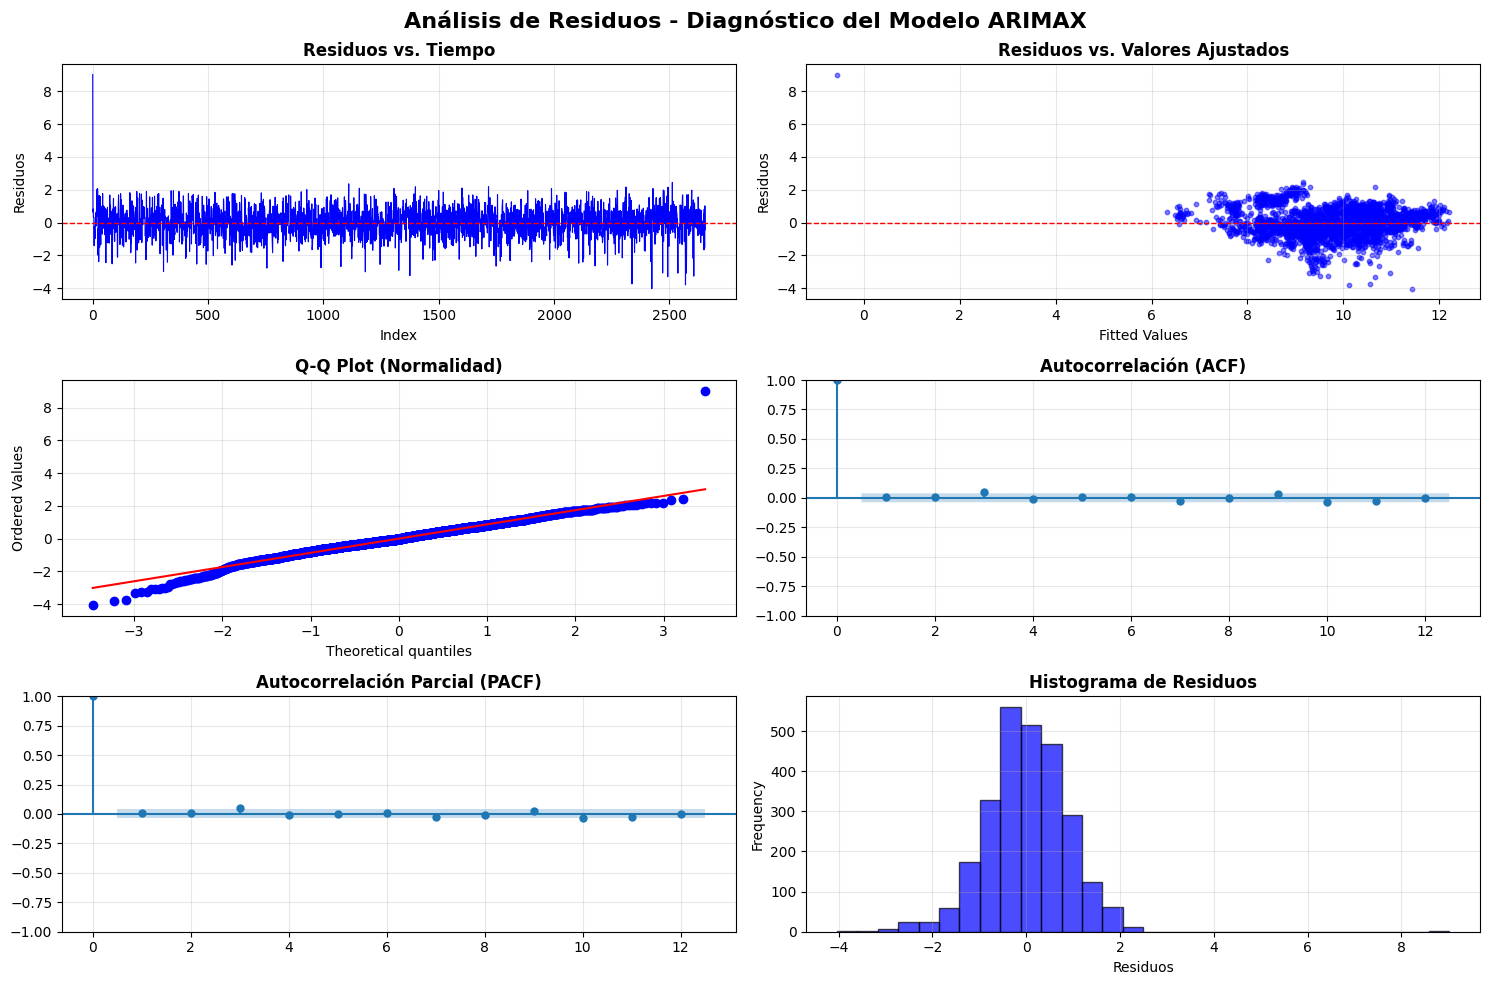

In [8]:

#  RESIDUOS
residuals = autoarimax_model.resid()
print("\n----------------- Residuals White Noise Test (Box-Cox) -----------------")
sa.residual_white_noise_test(residuals)
print("-----------------------------------------------------------------------")

# DIAGNÓSTICO DE RESIDUOS 
residuals_boxcox = autoarimax_model.arima_res_.resid
fitted_values_boxcox = autoarimax_model.arima_res_.fittedvalues
sa.analysis_residuals(residuals_boxcox, fitted_values_boxcox)

## BONDAD DEL AJUSTE Y PREDICCIÓN

In [9]:
# BONDAD DEL AJUSTE: Valores ajustados en TRAIN (in-sample)
# ============================================================================

# Obtener valores ajustados del modelo (en escala log)
fitted_train_log = autoarimax_model.predict_in_sample(X=x_train_exogs)

# Revertir transformación log1p para obtener valores en escala original
y_train_fitted = np.expm1(fitted_train_log)
y_train_real = train_data["volume.sales"].values

# Verificar dimensiones
print(f"Observaciones en TRAIN: {len(y_train_real)}")
print(f"Valores ajustados: {len(y_train_fitted)}")
print(f"Rango valores reales: [{y_train_real.min():.2f}, {y_train_real.max():.2f}]")
print(f"Rango valores ajustados: [{y_train_fitted.min():.2f}, {y_train_fitted.max():.2f}]")

Observaciones en TRAIN: 2656
Valores ajustados: 2656
Rango valores reales: [452.36, 539900.60]
Rango valores ajustados: [-0.43, 200495.87]


In [10]:
# PREDICCIÓN: Forecast en TEST (out-of-sample)
# ============================================================================

# Predicción out-of-sample usando las variables exógenas de test
forecast_test_log = autoarimax_model.predict(n_periods=len(test_data), X=x_test_exogs)

# Revertir transformación log1p para obtener valores en escala original
y_test_pred = np.expm1(forecast_test_log)
y_test_real = test_data["volume.sales"].values

# Verificar dimensiones
print(f"Observaciones en TEST: {len(y_test_real)}")
print(f"Predicciones: {len(y_test_pred)}")
print(f"Rango valores reales: [{y_test_real.min():.2f}, {y_test_real.max():.2f}]")
print(f"Rango predicciones: [{y_test_pred.min():.2f}, {y_test_pred.max():.2f}]")

Observaciones en TEST: 600
Predicciones: 600
Rango valores reales: [747.10, 442104.75]
Rango predicciones: [793.73, 195960.57]


In [11]:
# ============================================================================
# MÉTRICAS GLOBALES: Comparativa Train (Bondad Ajuste) vs Test (Predicción)
# ============================================================================
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

def smape(y_true, y_pred):
    """Symmetric Mean Absolute Percentage Error"""
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    return 100 * np.mean(2 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred) + 1e-8))

# Métricas TRAIN (Bondad del Ajuste)
mae_train = mean_absolute_error(y_train_real, y_train_fitted)
rmse_train = np.sqrt(mean_squared_error(y_train_real, y_train_fitted))
r2_train = r2_score(y_train_real, y_train_fitted)
smape_train = smape(y_train_real, y_train_fitted)

# Métricas TEST (Predicción)
mae_test = mean_absolute_error(y_test_real, y_test_pred)
rmse_test = np.sqrt(mean_squared_error(y_test_real, y_test_pred))
r2_test = r2_score(y_test_real, y_test_pred)
smape_test = smape(y_test_real, y_test_pred)

# Mostrar tabla comparativa
print("=" * 70)
print("MÉTRICAS GLOBALES DEL MODELO ARIMAX")
print("=" * 70)
print(f"{'Métrica':<15} {'TRAIN (Bondad Ajuste)':>25} {'TEST (Predicción)':>25}")
print("-" * 70)
print(f"{'MAE':<15} {mae_train:>25,.2f} {mae_test:>25,.2f}")
print(f"{'RMSE':<15} {rmse_train:>25,.2f} {rmse_test:>25,.2f}")
print(f"{'R²':<15} {r2_train:>25.4f} {r2_test:>25.4f}")
print(f"{'sMAPE (%)':<15} {smape_train:>25.2f} {smape_test:>25.2f}")
print("=" * 70)
print(f"\nObservaciones TRAIN: {len(y_train_real)}")
print(f"Observaciones TEST: {len(y_test_real)}")

MÉTRICAS GLOBALES DEL MODELO ARIMAX
Métrica             TRAIN (Bondad Ajuste)         TEST (Predicción)
----------------------------------------------------------------------
MAE                             19,863.66                 22,580.47
RMSE                            36,821.94                 42,765.44
R²                                 0.5748                    0.3913
sMAPE (%)                           60.36                     61.19

Observaciones TRAIN: 2656
Observaciones TEST: 600


In [12]:
# ============================================================================
# MÉTRICAS POR SERIE INDIVIDUAL
# ============================================================================

# Crear DataFrames con resultados para train y test
train_results = train_data[["date", "series_id", "volume.sales"]].copy()
train_results["y_pred"] = y_train_fitted
train_results["y_true"] = y_train_real

test_results = test_data[["date", "series_id", "volume.sales"]].copy()
test_results["y_pred"] = y_test_pred
test_results["y_true"] = y_test_real

# Función para calcular métricas por grupo
def metrics_by_series(df):
    if len(df) < 2:
        return pd.Series({
            'n_obs': len(df),
            'MAE': np.nan,
            'RMSE': np.nan,
            'sMAPE': np.nan,
            'R2': np.nan
        })
    return pd.Series({
        'n_obs': len(df),
        'MAE': mean_absolute_error(df['y_true'], df['y_pred']),
        'RMSE': np.sqrt(mean_squared_error(df['y_true'], df['y_pred'])),
        'sMAPE': smape(df['y_true'].values, df['y_pred'].values),
        'R2': r2_score(df['y_true'], df['y_pred'])
    })

# Calcular métricas por serie para TRAIN
series_metrics_train = train_results.groupby('series_id').apply(metrics_by_series).reset_index()
series_metrics_train = series_metrics_train.sort_values('MAE', ascending=True)

# Calcular métricas por serie para TEST
series_metrics_test = test_results.groupby('series_id').apply(metrics_by_series).reset_index()
series_metrics_test = series_metrics_test.sort_values('MAE', ascending=True)

# Mostrar resumen TRAIN
print("=" * 80)
print("MÉTRICAS POR SERIE - TRAIN (Bondad del Ajuste)")
print("=" * 80)
print(f"\nTop 5 mejores series (menor MAE):")
print(series_metrics_train.head(5).to_string(index=False))
print(f"\nTop 5 peores series (mayor MAE):")
print(series_metrics_train.tail(5).to_string(index=False))

# Mostrar resumen TEST
print("\n" + "=" * 80)
print("MÉTRICAS POR SERIE - TEST (Predicción)")
print("=" * 80)
print(f"\nTop 5 mejores series (menor MAE):")
print(series_metrics_test.head(5).to_string(index=False))
print(f"\nTop 5 peores series (mayor MAE):")
print(series_metrics_test.tail(5).to_string(index=False))

print(f"\n\nTotal series en TRAIN: {len(series_metrics_train)}")
print(f"Total series en TEST: {len(series_metrics_test)}")

MÉTRICAS POR SERIE - TRAIN (Bondad del Ajuste)

Top 5 mejores series (menor MAE):
                              series_id  n_obs        MAE        RMSE     sMAPE        R2
brand-35_supermarket-B_vegan_0 - 350 GR   29.0 463.970869  560.048721 43.237230 -2.296827
   other_supermarket-B_vegan_0 - 350 GR   29.0 606.352436  725.686549 32.863111 -0.269929
brand-15_supermarket-A_vegan_0 - 350 GR   29.0 616.445783  748.584896 14.960109 -0.152722
other_supermarket-C_standard_0 - 350 GR   29.0 764.237149  911.867216 16.398858  0.434121
brand-14_supermarket-B_light_0 - 350 GR   27.0 942.905656 1141.338960 41.080110 -0.124143

Top 5 peores series (mayor MAE):
                                    series_id  n_obs           MAE          RMSE     sMAPE         R2
brand-15_supermarket-A_standard_701 - 1000 GR   29.0  62295.733215  77561.557491 39.528115  -0.514992
 brand-15_supermarket-C_standard_351 - 500 GR   29.0  70979.390388  73807.222859 91.324448 -10.050648
 brand-35_supermarket-D_standard_351 -

In [13]:
# SELECCIONAR SERIE PARA VISUALIZAR

available_series = test_results['series_id'].unique()

# SERIE_SELECCIONADA = available_series[0]  
SERIE_SELECCIONADA = 'brand-14_supermarket-A_standard_701 - 1000 GR'

# comprobar que la serie seleccionada esta en available_series
if SERIE_SELECCIONADA in available_series:
    print(f"\n>>> Serie seleccionada: {SERIE_SELECCIONADA}")
else:
    print(f"\n>>> Serie seleccionada: {SERIE_SELECCIONADA}")
    print('no esta en available_series')


>>> Serie seleccionada: brand-14_supermarket-A_standard_701 - 1000 GR


SERIE: brand-14_supermarket-A_standard_701 - 1000 GR
TRAIN: 29 observaciones | 2021-01-31 00:00:00 a 2023-05-31 00:00:00
TEST:  7 observaciones | 2023-06-30 00:00:00 a 2023-12-31 00:00:00
----------------------------------------------------------------------
Métrica             TRAIN (Bondad Ajuste)         TEST (Predicción)
----------------------------------------------------------------------
MAE                             25,211.59                 38,244.89
RMSE                            31,379.00                 46,428.09
R²                                -0.4440                   -1.2775
sMAPE (%)                           38.69                     48.93


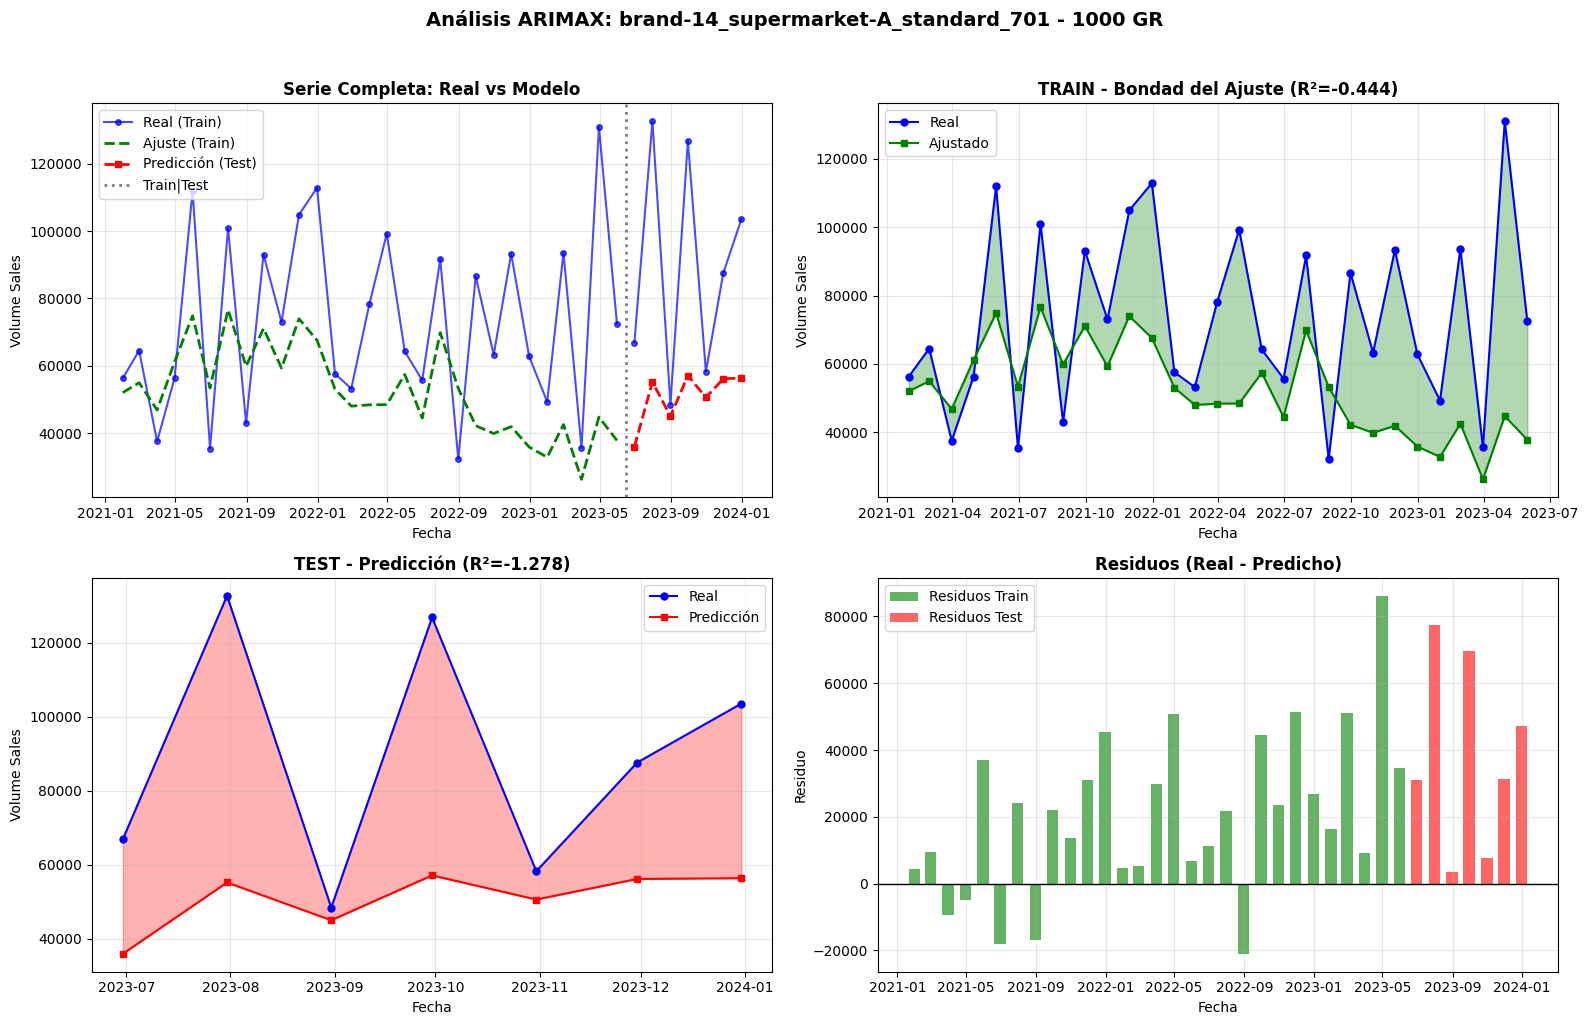

In [14]:
# VISUALIZACIÓN DE LA SERIE SELECCIONADA: Train (Ajuste) + Test (Predicción)
# ============================================================================

# Filtrar datos de la serie seleccionada
serie_train = train_results[train_results['series_id'] == SERIE_SELECCIONADA].copy()
serie_test = test_results[test_results['series_id'] == SERIE_SELECCIONADA].copy()
serie_train = serie_train.sort_values('date')
serie_test = serie_test.sort_values('date')

# Información de fechas
print("=" * 70)
print(f"SERIE: {SERIE_SELECCIONADA}")
print("=" * 70)
print(f"TRAIN: {len(serie_train)} observaciones | {serie_train['date'].min()} a {serie_train['date'].max()}")
print(f"TEST:  {len(serie_test)} observaciones | {serie_test['date'].min()} a {serie_test['date'].max()}")

# Calcular métricas de la serie en TRAIN
if len(serie_train) > 1:
    serie_mae_train = mean_absolute_error(serie_train['y_true'], serie_train['y_pred'])
    serie_rmse_train = np.sqrt(mean_squared_error(serie_train['y_true'], serie_train['y_pred']))
    serie_r2_train = r2_score(serie_train['y_true'], serie_train['y_pred'])
    serie_smape_train = smape(serie_train['y_true'].values, serie_train['y_pred'].values)
else:
    serie_mae_train = serie_rmse_train = serie_r2_train = serie_smape_train = np.nan

# Calcular métricas de la serie en TEST
if len(serie_test) > 1:
    serie_mae_test = mean_absolute_error(serie_test['y_true'], serie_test['y_pred'])
    serie_rmse_test = np.sqrt(mean_squared_error(serie_test['y_true'], serie_test['y_pred']))
    serie_r2_test = r2_score(serie_test['y_true'], serie_test['y_pred'])
    serie_smape_test = smape(serie_test['y_true'].values, serie_test['y_pred'].values)
else:
    serie_mae_test = serie_rmse_test = serie_r2_test = serie_smape_test = np.nan

# Mostrar métricas
print("-" * 70)
print(f"{'Métrica':<15} {'TRAIN (Bondad Ajuste)':>25} {'TEST (Predicción)':>25}")
print("-" * 70)
print(f"{'MAE':<15} {serie_mae_train:>25,.2f} {serie_mae_test:>25,.2f}")
print(f"{'RMSE':<15} {serie_rmse_train:>25,.2f} {serie_rmse_test:>25,.2f}")
print(f"{'R²':<15} {serie_r2_train:>25.4f} {serie_r2_test:>25.4f}")
print(f"{'sMAPE (%)':<15} {serie_smape_train:>25.2f} {serie_smape_test:>25.2f}")
print("=" * 70)

# ============================================================================
# GRÁFICO
# ============================================================================
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# --- Subplot 1: Serie completa (Train + Test) ---
ax1 = axes[0, 0]
# Train: real y ajuste
ax1.plot(serie_train['date'], serie_train['y_true'], 'b-o', label='Real (Train)', markersize=4, alpha=0.7)
ax1.plot(serie_train['date'], serie_train['y_pred'], 'g--', label='Ajuste (Train)', linewidth=2)
# Test: real y predicción
ax1.plot(serie_test['date'], serie_test['y_true'], 'b-o', markersize=4, alpha=0.7)
ax1.plot(serie_test['date'], serie_test['y_pred'], 'r--s', label='Predicción (Test)', markersize=5, linewidth=2)
# Línea vertical separando train/test
if len(serie_train) > 0 and len(serie_test) > 0:
    split_date = serie_train['date'].max() + (serie_test['date'].min() - serie_train['date'].max()) / 2
    ax1.axvline(x=split_date, color='gray', linestyle=':', linewidth=2, label='Train|Test')
ax1.set_title(f'Serie Completa: Real vs Modelo', fontsize=12, fontweight='bold')
ax1.set_xlabel('Fecha')
ax1.set_ylabel('Volume Sales')
ax1.legend(loc='upper left')
ax1.grid(True, alpha=0.3)

# --- Subplot 2: Solo TRAIN (Bondad del Ajuste) ---
ax2 = axes[0, 1]
ax2.plot(serie_train['date'], serie_train['y_true'], 'b-o', label='Real', markersize=5)
ax2.plot(serie_train['date'], serie_train['y_pred'], 'g-s', label='Ajustado', markersize=5)
ax2.fill_between(serie_train['date'], serie_train['y_true'], serie_train['y_pred'], alpha=0.3, color='green')
ax2.set_title(f'TRAIN - Bondad del Ajuste (R²={serie_r2_train:.3f})', fontsize=12, fontweight='bold')
ax2.set_xlabel('Fecha')
ax2.set_ylabel('Volume Sales')
ax2.legend()
ax2.grid(True, alpha=0.3)

# --- Subplot 3: Solo TEST (Predicción) ---
ax3 = axes[1, 0]
ax3.plot(serie_test['date'], serie_test['y_true'], 'b-o', label='Real', markersize=5)
ax3.plot(serie_test['date'], serie_test['y_pred'], 'r-s', label='Predicción', markersize=5)
ax3.fill_between(serie_test['date'], serie_test['y_true'], serie_test['y_pred'], alpha=0.3, color='red')
ax3.set_title(f'TEST - Predicción (R²={serie_r2_test:.3f})', fontsize=12, fontweight='bold')
ax3.set_xlabel('Fecha')
ax3.set_ylabel('Volume Sales')
ax3.legend()
ax3.grid(True, alpha=0.3)

# --- Subplot 4: Residuos de la serie ---
ax4 = axes[1, 1]
residuos_train = serie_train['y_true'] - serie_train['y_pred']
residuos_test = serie_test['y_true'] - serie_test['y_pred']
ax4.bar(serie_train['date'], residuos_train, color='green', alpha=0.6, label='Residuos Train', width=20)
ax4.bar(serie_test['date'], residuos_test, color='red', alpha=0.6, label='Residuos Test', width=20)
ax4.axhline(y=0, color='black', linestyle='-', linewidth=1)
ax4.set_title('Residuos (Real - Predicho)', fontsize=12, fontweight='bold')
ax4.set_xlabel('Fecha')
ax4.set_ylabel('Residuo')
ax4.legend()
ax4.grid(True, alpha=0.3)

plt.suptitle(f'Análisis ARIMAX: {SERIE_SELECCIONADA}', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()